# Grid World --- past all grids
##### Charles Zhang
##### Jun 17

###  1. Cover and Get Back

In [1]:
import numpy as np

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 4
START = (0, 0)
END = (0, 0)

In [3]:
class State:

    def __init__(self, state=START):
        self.board = np.zeros([BOARD_ROWS, BOARD_COLS])
        self.state = state    # tuple of the coordinate
        self.is_end = False

    def check_end(self):
        if self.state == END:
            self.is_end = True

    def next_position(self, action):
        if action == "up":
            next_state = (self.state[0] - 1, self.state[1])
        elif action == "down":
            next_state = (self.state[0] + 1, self.state[1])
        elif action == "left":
            next_state = (self.state[0], self.state[1] - 1)
        else:
            next_state = (self.state[0], self.state[1] + 1)
        if (next_state[0] >= 0) and (next_state[0] < BOARD_ROWS):
            if (next_state[1] >= 0) and (next_state[1] < BOARD_COLS):
                return next_state
        return self.state

In [4]:
class Agent:

    def __init__(self):
        self.actions = ["up", "down", "left", "right"]      # space
        self.State = State()
        self.is_end = self.State.is_end
        self.alpha = 0.3
        self.exp_rate = 1
        self.decay_gamma = 0.9
        self.Q_values = {}             # init Q values (dict)
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.Q_values[(i, j)] = {}
                for a in self.actions:
                    self.Q_values[(i, j)][a] = 0
        self.past_all = []
        for i in range(BOARD_ROWS):
            t = []
            for j in range(BOARD_COLS): 
                t.append(False)
            self.past_all.append(t)
        self.steps = []
        self.past_time = np.zeros([BOARD_ROWS, BOARD_COLS])

    def optimal_action(self):
        max_value = -1000000
        action = ""
        for a in self.actions:
            next_value = self.Q_values[self.State.state][a]
            if next_value >= max_value:
                action = a
                max_value = next_value
        return action
    
    def get_action(self):
        if np.random.uniform(0, 1) <= self.exp_rate:
            up = self.State.next_position("up")
            down = self.State.next_position("down")
            left = self.State.next_position("left")
            right = self.State.next_position("right")
            rule = [self.past_all[up[0]][up[1]] is True,
                    self.past_all[down[0]][down[1]] is True,
                    self.past_all[left[0]][left[1]] is True,
                    self.past_all[right[0]][right[1]] is True ]
            if all(rule):
                action = np.random.choice(self.actions)
                return action
            else:
                while True:
                    action = np.random.choice(self.actions)
                    next_state = self.State.next_position(action)
                    if self.past_all[next_state[0]][next_state[1]] == False:
                        return action
                    else:
                        continue
        else:
            return self.optimal_action()
    
    def give_reward(self):
        return -self.past_time[self.State.state[0]][self.State.state[1]]
    
    def set_action(self, action):    
        curr_state = self.State.state
        
        self.past_time[curr_state[0]][curr_state[1]] += 1
        
        self.past_all[curr_state[0]][curr_state[1]] = True
        next_state = self.State.next_position(action)  
        self.State = State(state=next_state)
        reward = self.give_reward()
        if self.past_all[next_state[0]][next_state[1]] is False:
            self.past_all[next_state[0]][next_state[1]] = True
#         if self.check_all_past():
#              reward += 15
        if self.State.state==START and self.check_all_past():
            reward += 15
        qs_of_next_state = []
        for q_value in self.Q_values[next_state]:  
            qs_of_next_state.append(self.Q_values[next_state][q_value])
        delta = self.alpha*(reward + self.decay_gamma*(max(qs_of_next_state)) -
                            self.Q_values[curr_state][action])
        self.Q_values[curr_state][action] = round(self.Q_values[curr_state][action]+delta, 2)
        

    def reset(self):
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                self.past_all[i][j] = False
        self.State = State()
        self.is_end = self.State.is_end
        self.past_time = np.zeros([BOARD_ROWS, BOARD_COLS])
    
    def check_all_past(self):
        for i in self.past_all:
            for j in i:
                if j is False:
                    return False
        return True

    def train(self, rounds=100):
        print("Training...")
        for r in range(rounds): 
            self.reset()
            self.exp_rate *= 0.9
            step = 0
            while True:
                action = self.get_action()
                self.set_action(action)
                self.State.check_end()
                self.is_end = self.State.is_end
                step += 1
                if (self.is_end == True) and (self.check_all_past() == True):
                #if self.check_all_past() == True:
                    break
            self.steps.append(step)
        print("Training finished!")

In [5]:
agent = Agent()
agent.train()

Training...
Training finished!


In [6]:
agent.Q_values

{(0, 0): {'down': -315.22, 'left': -309.4, 'right': -294.99, 'up': -311.19},
 (0, 1): {'down': -322.04, 'left': -310.87, 'right': -315.55, 'up': -314.59},
 (0, 2): {'down': -326.32, 'left': -294.67, 'right': -322.52, 'up': -323.33},
 (0, 3): {'down': -332.65, 'left': -329.39, 'right': -333.12, 'up': -329.28},
 (1, 0): {'down': -317.52, 'left': -315.54, 'right': -291.94, 'up': -317.05},
 (1, 1): {'down': -310.75, 'left': -321.37, 'right': -328.26, 'up': -329.58},
 (1, 2): {'down': -331.77, 'left': -330.88, 'right': -330.2, 'up': -329.22},
 (1, 3): {'down': -329.15, 'left': -331.05, 'right': -329.49, 'up': -330.17},
 (2, 0): {'down': -326.3, 'left': -327.74, 'right': -326.14, 'up': -329.83},
 (2, 1): {'down': -330.38, 'left': -327.65, 'right': -285.22, 'up': -330.49},
 (2, 2): {'down': -343.69, 'left': -338.99, 'right': -296.0, 'up': -338.67},
 (2, 3): {'down': -338.18, 'left': -337.75, 'right': -335.04, 'up': -308.17}}

In [7]:
for i in range(BOARD_ROWS):
    print('------------------------------------')
    row_string = "| "
    for j in range(BOARD_COLS):
        best_val = -1000
        for a in agent.Q_values[(i,j)]:
            if agent.Q_values[(i,j)][a] > best_val:
                best_val = agent.Q_values[(i,j)][a]
                best_move = a            
        row_string = row_string + " " + best_move + " |"
    print(row_string)
print('------------------------------------')

------------------------------------
|  right | left | left | up |
------------------------------------
|  right | down | up | down |
------------------------------------
|  right | right | right | up |
------------------------------------


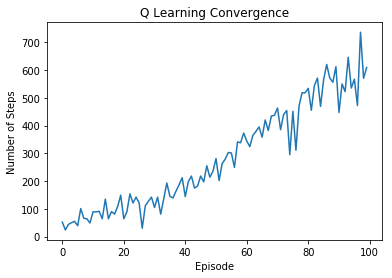

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
x = []
for i in range(100):
    x.append(i)
y = agent.steps
plt.plot(x,y)
plt.ylabel('Number of Steps')
plt.xlabel('Episode')
plt.title('Q Learning Convergence')
plt.show()

In [9]:
min(agent.steps)

24